# Evaluation of the results

In [25]:
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
import networkx as nx

warnings.filterwarnings("error")
np.set_printoptions(linewidth=120, precision=2)

MODE = "a"

## Rearrange adjacency matrix based on node dependencies

From Crochiere & Oppenheim (1975):
> The procedure begins by searching the network for all nodes which do not have coefficient branches entering them. These nodes are then separated from the network and assigned to node set { n l }, as depicted in Fig. 2(a). It is apparent that these node values can be computed without knowledge of any of the node values in the network for time index n. Their evaluation may require only past node values for time n - 1 due to coefficient-delay branches, or present source input values at time n.

In [26]:

import os
import re
fitness = 0
best = ""
for filename in os.listdir("../build/Release"):
    if re.match(r".*Gen-\d+\.json$", filename):
        with open("../build/Release/" + filename) as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                # skip files that are not valid JSON
                continue
            if data["fitness"] > fitness:
                fitness = data["fitness"]
                best = filename
            
if best == "":
    print("No files found")
    exit(1)

print("Best fitness:", fitness)
print("Best file:", best)

# build matrix from json file instead
with open("../build/Release/" + best) as f:
    data = json.load(f)
    type_layer = data["type_layer"]
    value_layer = data["value_layer"]
    N = data["N"]
    readOutput = data["output"]
    fitnessJson = data["fitness"]
    # inputNodeIndex = data["inputNode"]
    # outputNodeIndex = data["outputNode"]
    
matrix = np.zeros((2, N, N))
for i in range(N):
    for j in range(N):
        matrix[0][i][j] = type_layer[i*N+j]
        matrix[1][i][j] = value_layer[i*N+j]

print("First layer of the matrix:")
print(matrix[0], end="\n\n")
print("Second layer of the matrix:")
print(matrix[1])

Best fitness: 0.9801620451718533
Best file: prueba_Gen-592.json
First layer of the matrix:
[[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 0. 0.]]

Second layer of the matrix:
[[ 0.    0.   -0.31  0.    0.    0.    0.    0.   -0.    0.   -0.    0.    0.16  0.    0.07]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 

In [27]:
fc = matrix[1] * (matrix[0] == 1)

def getMatrixesN(fc):
    n = []
    nodeIdxs = range(fc.shape[0])

    while True:
        n.append([j for j in nodeIdxs if not np.any(fc[:, j])])
        if n[-1] == []:
            n.pop()
            break
        nodeIdxs = [j for j in nodeIdxs if j not in n[-1]]
        fc[n[-1], :] = 0
    return n

orderedDependencies = getMatrixesN(fc)
print("Ordered dependencies:")
for i, dep in enumerate(orderedDependencies):
    print(f"n{i+1}: {dep}")


Ordered dependencies:
n1: [0, 1, 3, 4, 5, 6, 7, 9, 11]
n2: [2, 12]
n3: [8, 13, 14]
n4: [10]


This transforms the list of nodes $\{n_1, n_2, \ldots, n_f\}$ into an ordered list of nodes which, if we compute in order, it's ensured to be computable. It also gives them a new ID. This will be used to obtain the *Precedence Form*.

In [28]:
import itertools
pairs = {}
newNodeNames = range(N)
orderedDependencies_singleList = list(itertools.chain(*orderedDependencies))
print("Ordered dependencies:")
print(orderedDependencies_singleList)
for i in range(N):
    pairs[newNodeNames[i]] = orderedDependencies_singleList[i]
print("Pairs:")
print(json.dumps(pairs, indent=4))

Ordered dependencies:
[0, 1, 3, 4, 5, 6, 7, 9, 11, 2, 12, 8, 13, 14, 10]
Pairs:
{
    "0": 0,
    "1": 1,
    "2": 3,
    "3": 4,
    "4": 5,
    "5": 6,
    "6": 7,
    "7": 9,
    "8": 11,
    "9": 2,
    "10": 12,
    "11": 8,
    "12": 13,
    "13": 14,
    "14": 10
}


Interchange the nodes using the old matrix's connections and the newNodeNames.

In [29]:
newMatrix = np.zeros_like(matrix)

# for _ in pairs:
for i in range(N):
    for j in range(N):
        newMatrix[0][i][j] = matrix[0][pairs[i]][pairs[j]]
        newMatrix[1][i][j] = matrix[1][pairs[i]][pairs[j]]

In [30]:
def isComputable(reorderedMatrix):
    return not np.any(np.float64(np.triu(newMatrix[0].T == 1)))

print("Is the matrix computable?", isComputable(newMatrix))

print(newMatrix[0], end="\n\n")

newMatrix = matrix

Is the matrix computable? True
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 2. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]]



In [31]:
import csv
    
target_json_files = [os.path.join('../build/Release', f) for f in os.listdir('../build/Release') if re.match(r'.*TARGET\.json$', f)]
if not target_json_files:
    print("No TARGET.json file found in ../build/Release")
    exit(1)
    
with open(target_json_files[0], 'r') as f_json:
    data_json = json.load(f_json)

expected = data_json["Target"]
print("Expected output:")
print(expected)

b = data_json["b"]
a = data_json["a"]
print("b coefficients:", b)
print("a coefficients:", a)

L = len(expected)
n = np.arange(0, L, 1)

readOutput_arr = np.asarray(readOutput, dtype=np.float64)
expected_arr = np.asarray(expected, dtype=np.float64)
min_len = min(len(readOutput_arr), len(expected_arr))
readOutput_arr = readOutput_arr[:min_len]
expected_arr = expected_arr[:min_len]

readOutput_arr = np.nan_to_num(readOutput_arr, nan=0.0, posinf=0.0, neginf=0.0)
expected_arr = np.nan_to_num(expected_arr, nan=0.0, posinf=0.0, neginf=0.0)

MSE_json = np.mean((readOutput_arr - expected_arr)**2)
computedFitnessFromJsonOutput = 1 / (1 + MSE_json)

np.set_printoptions(linewidth=120, precision=3, suppress=True)

Expected output:
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.95, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.8573749999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8145062499999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7737809374999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7350918906249998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.6983372960937497, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6634204312890623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.6302494097246091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5987369392383786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5688000922764596, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5403600876626365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5133420832795047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48767497911552943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.46329123015975293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44012666865176525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.41812033521917696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3972143184582181, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.37735360253530714, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.358485

Best fitness: 0.9801620451718533
Best file: prueba_Gen-592.json


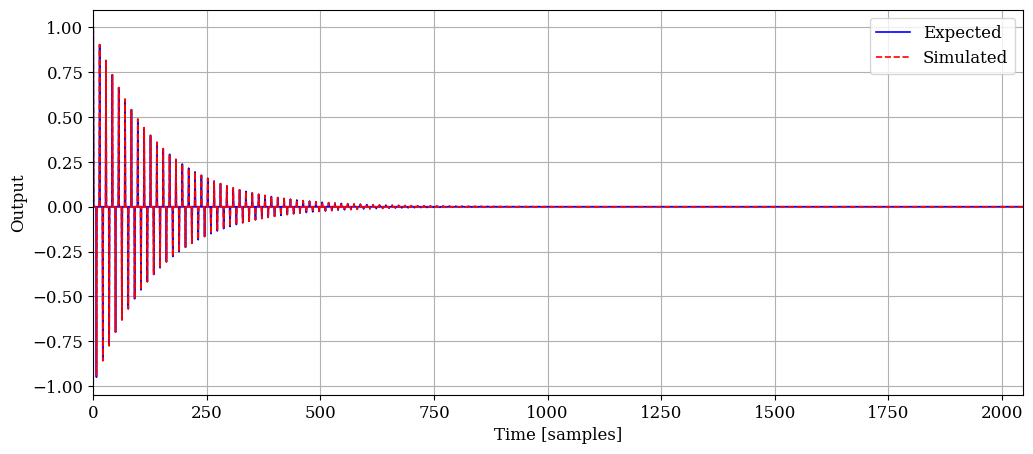

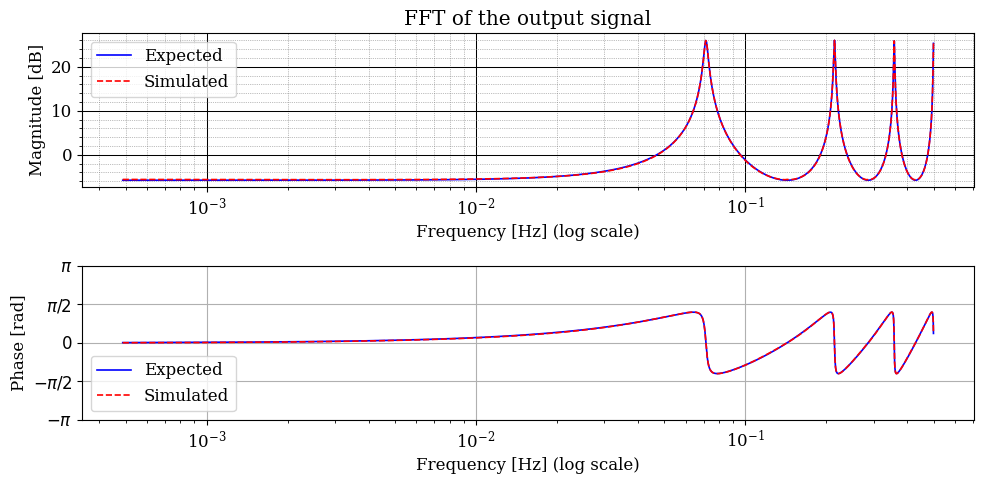

In [32]:
print("Best fitness:", fitness)
print("Best file:", best)

plt.figure(figsize=(12, 5))
plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 100

plt.plot(n, expected, '-', color='blue', linewidth=1.2)
plt.plot(n, readOutput, '--', color='red', linewidth=1.2)
plt.legend([
    "Expected",
    "Simulated",
    ])
plt.grid('both')
plt.xlabel("Time [samples]")
# plt.xlim([0, 2000])
plt.xlim([0, L-1])
plt.ylabel("Output")
plt.show()

from scipy import fft

yf_expected = fft.fft(expected, L)
yf_readOutput = fft.fft(readOutput, L)

# Create frequency axis (avoid zero for log scale)
freq = np.fft.fftfreq(L, d=1.0)  # Normalized frequency
freq_positive = freq[1:L//2]  # Only positive frequencies, excluding DC

plt.figure(figsize=(10, 5))
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 100

plt.subplot(2, 1, 1)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(which='major', linestyle='-', linewidth='0.75', color='black')
plt.semilogx(freq_positive, 20*np.log10(np.abs(yf_expected[1:L//2])), '-', color='blue', linewidth=1.2)
plt.semilogx(freq_positive, 20*np.log10(np.abs(yf_readOutput[1:L//2])), '--', color='red', linewidth=1.2)
plt.xlabel("Frequency [Hz] (log scale)")
plt.ylabel("Magnitude [dB]")
plt.title("FFT of the output signal")
plt.legend(["Expected", "Simulated"])

plt.subplot(2, 1, 2)
plt.semilogx(freq_positive, np.angle(yf_expected[1:L//2]), '-', color='blue', linewidth=1.2)
plt.semilogx(freq_positive, np.angle(yf_readOutput[1:L//2]), '--', color='red', linewidth=1.2)
plt.yticks(np.arange(-np.pi, np.pi + np.pi/2, np.pi/2), 
           [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
plt.ylabel("Phase [rad]")
plt.ylim([-np.pi, np.pi])
plt.grid()
plt.xlabel("Frequency [Hz] (log scale)")

plt.legend(["Expected", "Simulated"], loc="lower left")
plt.tight_layout()
plt.show()

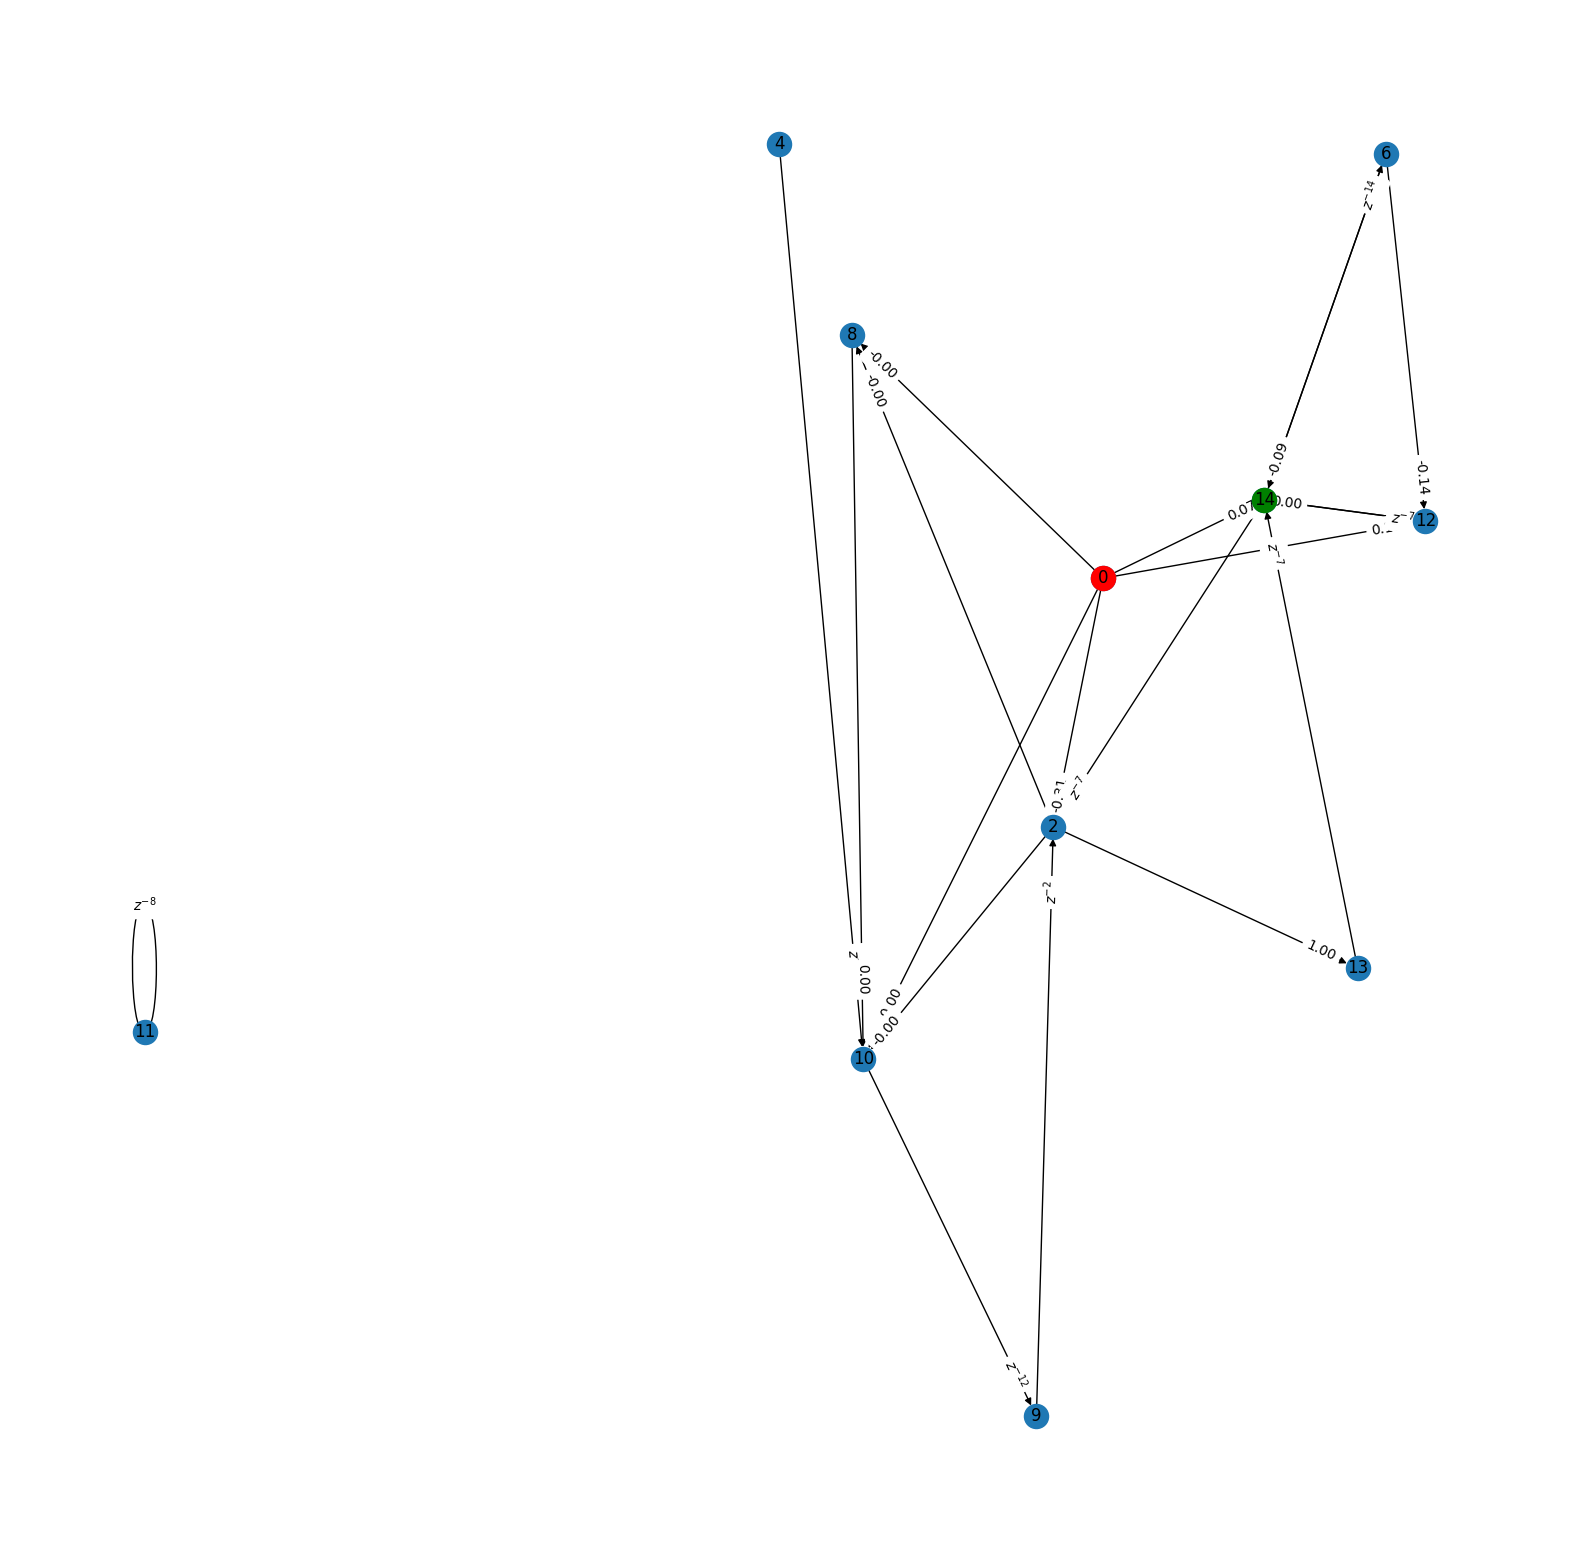

In [33]:
G = nx.DiGraph()
nodesToShow = [i for i in range(N) if np.any(matrix[0][i] == 1) or np.any(matrix[0][:, i] == 1)]
G.add_nodes_from(nodesToShow)

fig = plt.figure(1, figsize=(20, 20)) 
plt.axis('off')
edge_labels = {}
edges = []
for i in range(N):
    for j in range(N):
        if matrix[0][i][j] == 1:
            G.add_edge(i, j)
            edges.append((i, j))
            edge_labels[(i, j)] = f"{matrix[1][i][j]:.2f}" 
        elif matrix[0][i][j] == 2:
            G.add_edge(i, j)
            edges.append((i, j))
            edge_labels[(i, j)] = r"$z^{-" + str(int(matrix[1][i][j])) + "}$"
        

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=edges)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.9)
nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=[N-1], node_color='g')